In [1]:
!pip install easyocr keras-ocr -q

     |████████████████████████████████| 2.9 MB 36.8 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 47.6 MB 2.0 MB/s 
     |████████████████████████████████| 604 kB 51.8 MB/s 
     |████████████████████████████████| 120 kB 57.8 MB/s 
     |████████████████████████████████| 9.5 MB 50.3 MB/s 
     |████████████████████████████████| 965 kB 51.0 MB/s 
     |████████████████████████████████| 50 kB 3.2 MB/s 


In [2]:
!pip install pytesseract -q
!sudo apt install tesseract-ocr -q

     |████████████████████████████████| 3.1 MB 23.6 MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 27 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB

### Experiments

In [23]:
# imports

import os
import warnings

import cv2
import easyocr
import imutils
import keras_ocr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r"/usr/bin/tesseract"
warnings.filterwarnings("ignore")


class Car:
    def __init__(self):
        pass

    def __filters(self, img):
        """
        Preprocessing images for the OpenCV method.

        Args:
            img: image that will be preprocessed

        Return:
            preprocessed image with some new features -> gray, bilateralfilter and edged
        """
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bfilter = cv2.bilateralFilter(gray, 11, 17, 17)  # Noise reduction
        edged = cv2.Canny(bfilter, 30, 200)  # Edge detection
        return gray, bfilter, edged

    def __search_plate_and_crop(self, img, edged, gray):
        """
        Use the preprocessed images to find countours and consequently crop the images

        Args:
            img: real image
            edged: edged image (_filters method)
            gray: gray image (_filters method)

        Return:
            image with the contours, his coordinates and the cropped.
        """
        keypoints = cv2.findContours(
            edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )
        contours = imutils.grab_contours(keypoints)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

        location = 0
        for contour in contours:
            approx = cv2.approxPolyDP(contour, 10, True)
            if len(approx) == 4:
                location = approx
                break
        mask = np.zeros(gray.shape, np.uint8)
        new_image = cv2.drawContours(mask, [location], 0, 255, -1)
        new_image = cv2.bitwise_and(img, img, mask=mask)

        (x, y) = np.where(mask == 255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        cropped_image = gray[x1 : x2 + 1, y1 : y2 + 1]
        return new_image, approx, cropped_image

    def __create_new_folder(self, path, folder_name):
        """
        Create a new folder based on the args.

        Args:
            path: path that will be created the new folder
            folder_name: the name of the folder that will be created in this path.

        Return:
            path of the new folder.
        """
        try:
            current_path = os.getcwd()
            os.chdir(".")
            path = os.getcwd()
            full_path = os.path.join(path, folder_name)
            os.makedirs(full_path)
            os.chdir(current_path)
            return full_path
        except OSError as error:
            print(f"Already have a folder called: {folder_name} in this directory")
            full_path = os.path.join(path, folder_name)
            return full_path

    def __plot_images(self, img1, img2, title1="", title2=""):
        fig = plt.figure(figsize=[15, 15])
        ax1 = fig.add_subplot(121)
        ax1.imshow(img1, cmap="gray")
        ax1.set(xticks=[], yticks=[], title=title1)

        ax2 = fig.add_subplot(122)
        ax2.imshow(img2, cmap="gray")
        ax2.set(xticks=[], yticks=[], title=title2)

        return fig

    def __resize_images(self, img):
        """
        Increase the image size if it is too small

        Args:
            img: real image

        Return:
            image with four times bigger.
        """
        widht, height = img.shape[:2]
        if widht <= 40 & height <= 40:
            img = cv2.resize(img, (widht * 4, height * 4))
        return img

    # Sample Method
    def OpenCVeasy(self, path, folder_name, show_steps=False):
        """
        Use threshold, edge detection to find countours for car plate detection. EasyOCR for image to text recognition.

        Args:
            path: directory path which contains the images
            folder_name: directory path which will contain the results
            show_steps: to show the steps of the preprocessing images

        Return:
            DataFrame.csv with the labeled plate of each car (image)
        """
        self.path = path
        self.folder_name = folder_name
        df_lista = []

        full_path = self.__create_new_folder(path, folder_name)

        for dir, subarch, archives in os.walk(path):
            for path_imagem in archives:
                try:
                    img = cv2.imread(path + "/" + str(path_imagem))
                    img = self.__resize_images(img)
                    gray, bfilter, edged = self.__filters(img)
                    new_image, approx, cropped_image = self.__search_plate_and_crop(
                        img, edged, gray
                    )

                    reader = easyocr.Reader(["en"])
                    result = reader.readtext(cropped_image)

                    text = result[0][-2]
                    df_lista.append((path_imagem, text.upper()))
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    res = cv2.putText(
                        img,
                        text=text,
                        org=(approx[1][0][0], approx[2][0][1] + 30),
                        fontFace=font,
                        fontScale=0.7,
                        color=(0, 255, 0),
                        thickness=3,
                        lineType=cv2.LINE_AA,
                    )
                    res = cv2.rectangle(
                        img, tuple(approx[0][0]), tuple(approx[2][0]), (0, 255, 0), 3
                    )
                    plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
                    plt.savefig(full_path + "/" + path_imagem)
                except IndexError as IE:
                    print(
                        f"\n\nOcorreu um erro de Index na imagem: {path_imagem}, porém continuando para a proxima imagem"
                    )
                    continue
                except Exception as error:
                    print(
                        f"\n\nOcorreu um erro na imagem: {path_imagem}, porém continuando para a proxima imagem"
                    )
                    continue

        df_aux = pd.DataFrame(df_lista)
        df_aux.rename(columns={0: "Image", 1: "Plate"}, inplace=True)
        df = df_aux.sort_values("Image").to_csv(
            full_path + "/" + "results.csv", index=False
        )

        if show_steps == True:
            self.__plot_images(img, gray, title1="original", title2="gray")
            self.__plot_images(gray, bfilter, title1="gray", title2="bfilter")
            self.__plot_images(bfilter, edged, title1="bfilter", title2="edged")
            self.__plot_images(
                img, cropped_image, title1="original", title2="cropped_image"
            )

        return df

    def YOLOeasy(self, path, folder_name):
        """
        Use yolov5 to crop the image to exclusively the plate (yolov5_crop_images.ipynb). EasyOCR to transform the plate into text.

        Args:
            path: directory path which contains the images (cropped images)
            folder_name: directory path which will contain the results

        Return:
            DataFrame.csv with the labeled plate of each car (image)
        """
        self.path = path
        self.folder_name = folder_name
        df_lista_yolo = []

        full_path = self.__create_new_folder(path, folder_name)

        for dir, subarch, archives in os.walk(path):
            for path_imagem in archives:
                try:
                    img = cv2.imread(path + "/" + str(path_imagem))
                    img = self.__resize_images(img)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    reader = easyocr.Reader(["en"])
                    result = reader.readtext(img)
                    text = result[0][-2]
                    df_lista_yolo.append((path_imagem, text.upper()))

                except IndexError as IE:
                    print(
                        f"\n\nOcorreu um erro de Index na imagem: {path_imagem}, porém continuando para a proxima imagem"
                    )
                    continue
                except Exception as error:
                    print(
                        f"\n\nOcorreu um erro na imagem: {path_imagem}, porém continuando para a proxima imagem"
                    )
                    continue

        df_aux = pd.DataFrame(df_lista_yolo)
        df_aux.rename(columns={0: "Image", 1: "Plate"}, inplace=True)
        df = df_aux.sort_values("Image").to_csv(
            full_path + "/" + "easy_results.csv", index=False
        )

        return df

    def YOLOpytesseract(self, path, folder_name):
        """
        Use yolov5 to crop the image to exclusively the plate (yolov5_crop_images.ipynb). PytesseractOCR to transform the plate into text.

        Args:
            path: directory path which contains the images (cropped images)
            folder_name: directory path which will contain the results

        Return:
            DataFrame.csv with the labeled plate of each car (image)
        """
        self.path = path
        self.folder_name = folder_name
        df_lista_yolo = []

        full_path = self.__create_new_folder(path, folder_name)
        custom_config = r'--psm 6'

        for dir, subarch, archives in os.walk(path):
            for path_imagem in archives:
                try:
                    img = cv2.imread(path + "/" + str(path_imagem))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    text = pytesseract.image_to_string(img, config = custom_config)
                    df_lista_yolo.append((path_imagem, text.upper()))

                except IndexError as IE:
                    print(
                        f"\n\nOcorreu um erro de Index na imagem: {path_imagem}, porém continuando para a proxima imagem"
                    )
                    continue
                except Exception as error:
                    print(
                        f"\n\nOcorreu um erro na imagem: {path_imagem}, porém continuando para a proxima imagem"
                    )
                    continue

        df_aux = pd.DataFrame(df_lista_yolo)
        df_aux.rename(columns={0: "Image", 1: "Plate"}, inplace=True)
        df = df_aux.sort_values("Image").to_csv(
            full_path + "/" + "pytesseract_results.csv", index=False
        )

        return df

    def YOLOkeras(self, path, folder_name, show_annotations=False):
        """
        Use yolov5 to crop the image to exclusively the plate (yolov5_crop_images.ipynb). KerasOCR to transform the plate into text.

        Args:
            path: directory path which contains the images
            folder_name: directory path which will contain the results

        Return:
            DataFrame.csv with the labeled plate of each car (image)
        """
        self.path = path
        self.folder_name = folder_name

        full_path = self.__create_new_folder(path, folder_name)

        pipeline_list = []
        df_keras = []
        for dir, subarch, archives in os.walk(path):
            for images in archives:
                pipeline_list = []
                path_images = f"{dir}/" + images
                pipeline_list.append(path_images)

                pipeline = keras_ocr.pipeline.Pipeline()
                pipeline_images = [keras_ocr.tools.read(img) for img in pipeline_list]
                prediction_groups = pipeline.recognize(pipeline_images)

                for content in prediction_groups:
                    print(f"\n --#-- Analysing {images} --#--\n")
                    for text, box in content:
                        df_keras.append((images, text.upper()))

        df_aux = pd.DataFrame(df_keras)
        df_aux.rename(columns={0: "Image", 1: "Plate"}, inplace=True)
        df = df_aux.sort_values("Image")
        df = df.groupby("Image").sum().to_csv(full_path + "/" + "keras_results.csv")

        if show_annotations == True:
            for image, pred in zip(pipeline_images, prediction_groups):
                fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                keras_ocr.tools.drawAnnotations(image=image, predictions=pred, ax=ax)

        return df

"""
To run the class above, do:

Car().OpenCVeasy(path = "/content/samples", folder_name = "opencv_detection") 
Car().YOLOeasy(path = "/content/samples", folder_name = "yolo_easy_detection")
Car().YOLOpytesseract(path = "/content/samples", folder_name = "pytesseract_detection")  
Car().YOLOkeras(path = "/content/samples", folder_name = "keras_detection") 
"""

'\nTo run the class above, do:\n\nCar().OpenCVeasy(path = "/content/samples", folder_name = "opencv_detection") \nCar().YOLOeasy(path = "/content/samples", folder_name = "yolo_easy_detection")\nCar().YOLOpytesseract(path = "/content/samples", folder_name = "pytesseract_detection")  \nCar().YOLOkeras(path = "/content/samples", folder_name = "keras_detection") \n'

In [9]:
Car().YOLOeasy(path = "/content/samples", folder_name = "easy_yolo")

Already have a folder called: easy_yolo in this directory


In [13]:
Car().YOLOpytesseract(path = "/content/samples", folder_name = "pyt_results")

Already have a folder called: pyt_results in this directory


In [24]:
Car().YOLOkeras(path = "/content/samples", folder_name = "keras_detection")

Already have a folder called: keras_detection in this directory
Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step

 --#-- Analysing Cars393.jpg --#--

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step

 --#-- Analysing Cars73.jpg --#--

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 2s 2s/step

 --#-- Analysing Cars418.jpg --#--

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step

 --#-- Analysing Cars299.jpg --#--



Already have a folder called: plate_detection in this directory


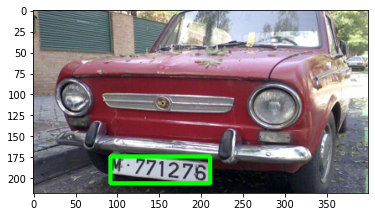

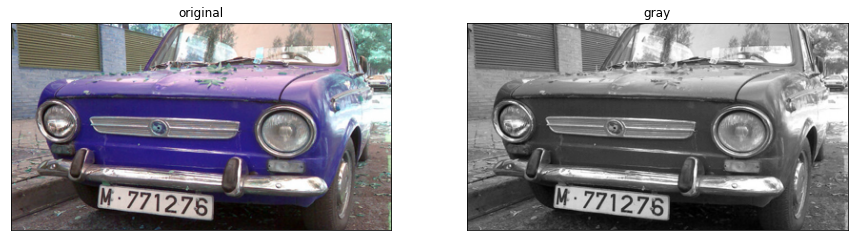

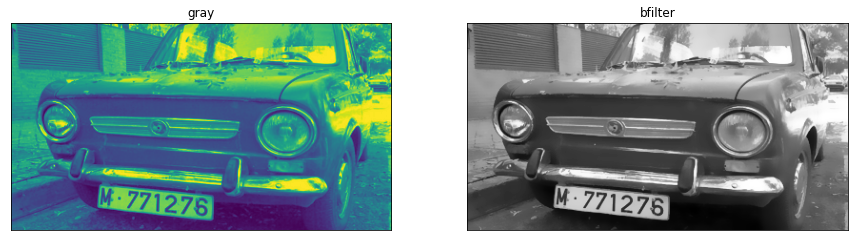

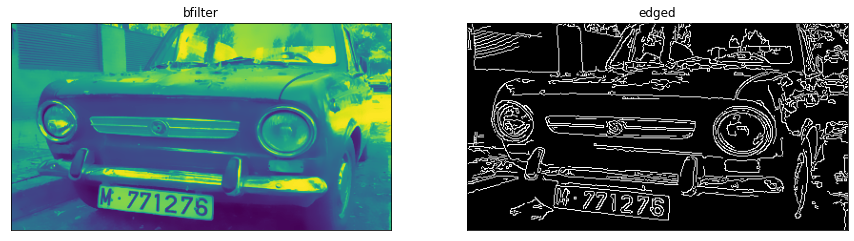

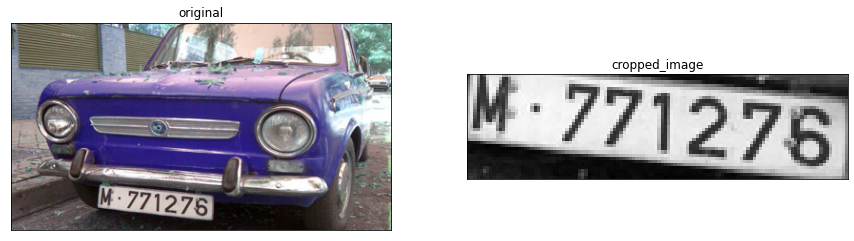

In [22]:
Car().plateDetection(path = "/content/plate", folder_name = "plate_detection", show_steps = True)